# 0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import datetime
import numpy as np
import seaborn as sns
import plotly
import xgboost as xgb
import random
import warnings
import pickle
import requests

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
                                                                                                        
from sklearn.linear_model  import LinearRegression, Lasso


from plotly                import express as px
from matplotlib            import gridspec
from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib.gridspec   import GridSpec
from scipy                 import stats
from boruta                import BorutaPy
from matplotlib            import pyplot as plt


# 1. HELPER FUNCTIONS

In [74]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use ('bmh')
    plt.rcParams['figure.figsize'] = [25,12] #set graph size
    plt.rcParams['font.size'] = 24
    display(HTML ('<style>.container { width:90% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def ml_error (model_name, y, yhat) : 
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error (y, yhat))
    
    return pd.DataFrame ( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index = [0])

def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def cross_validation (x_training, kfold, model_name, model):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed (range (1, kfold+1)):
        #start and end date for validation
        validation_start_day = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_day = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)
        
        #filtering datset
        training =  x_training[x_training['date'] < validation_start_day]
        validation =  x_training[(x_training['date'] >= validation_start_day) & (x_training['date'] <= validation_end_day)]
        
        #training and validartion dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis =1)
        ytraining = training['sales']
        
        #validation
        xvalidation = validation.drop(['date','sales'], axis =1)
        yvalidation = validation['sales']
        
        #model
        m = model.fit(xtraining, ytraining)
        
        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error (model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store performance of each iteraction
        mae_list.append (m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': round(np.mean(mae_list),2).astype(str) + ' +/- ' + round(np.std(mae_list),2).astype(str),
                         'MAPE CV':round(np.mean(mape_list),2).astype(str) + ' +/- ' + round(np.std(mape_list),2).astype(str),
                         'RMSE CV':round(np.mean(rmse_list),2).astype(str) + ' +/- ' + round(np.std(rmse_list),2).astype(str)}, index = [0] )

warnings.filterwarnings('ignore')

# 2. LOADING DATA

In [3]:
#read files - sales and locations
df_sales = pd.read_csv('Kaggle-data/train.csv', low_memory=False) 
df_stores = pd.read_csv('Kaggle-data/store.csv', low_memory=False)

#merge datasets
df_raw = pd.merge(df_sales, df_stores, how ='left', on ='Store')

# 3. DESCRIPTIVE ANALYSIS AND DATA CLEANING

In [4]:
#copy dataset
df1 = df_raw.copy()

#rename columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#build function 
snakecase = lambda x: inflection.underscore(x)
#apply function in cols_old
cols_new = list(map(snakecase, cols_old))
#rename
df1.columns = cols_new

#data dimensions
li = df1.shape[0]
co = df1.shape[1]
print(f'The number of rows is {li}')
print(f'The number of columns is {co}')

#data types
df1.dtypes
df1['date'] = pd.to_datetime(df1['date'], format = '%Y-%m-%d')

The number of rows is 1017209
The number of columns is 18


In [5]:
#fillout na

#competition_distance
#it was considered that if it is na, it has no close competition. So distance was filled with a high value 
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#filled with sales month date - so it will be as the competition started in the same month as the sale
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
#filled with sales year date - so it will be as the competition started in the same year as the sale
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
#filled with sales date - so it will be as the promo2 started in the same date as the sale
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
#filled with sales date - so it will be as the promo2 started in the same date as the sale
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
df1['promo_interval'].fillna(0, inplace= True)

#promo now
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12: 'Dec'} 
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['promo_now'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [6]:
#change types
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)      
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [7]:
#statistics
df2 = df1.copy()

#numeric data
num_attributes = df2.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df2.select_dtypes(exclude = ['int64', 'float64','datetime64[ns]'])

#central 
df_mean = pd.DataFrame(num_attributes.apply(np.mean))
df_median = pd.DataFrame(num_attributes.apply(np.median))

#dispersions
df_std = pd.DataFrame(num_attributes.apply(np.std))
df_max = pd.DataFrame(num_attributes.apply(max))
df_min = pd.DataFrame(num_attributes.apply(min))
df_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
df_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
df_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

statistics = pd.concat([df_mean, df_median, df_min, df_max, df_range, df_std, df_skew, df_kurtosis], axis=1).reset_index()
statistics.columns = ['attributes','mean','median','minimum','maximum','range','std','skewness','kurtosis']

statistics

,attributes,mean,median,minimum,maximum,range,std,skewness,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,321.908493,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997390,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.924283,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411506,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515591,-7.235657,124.071304


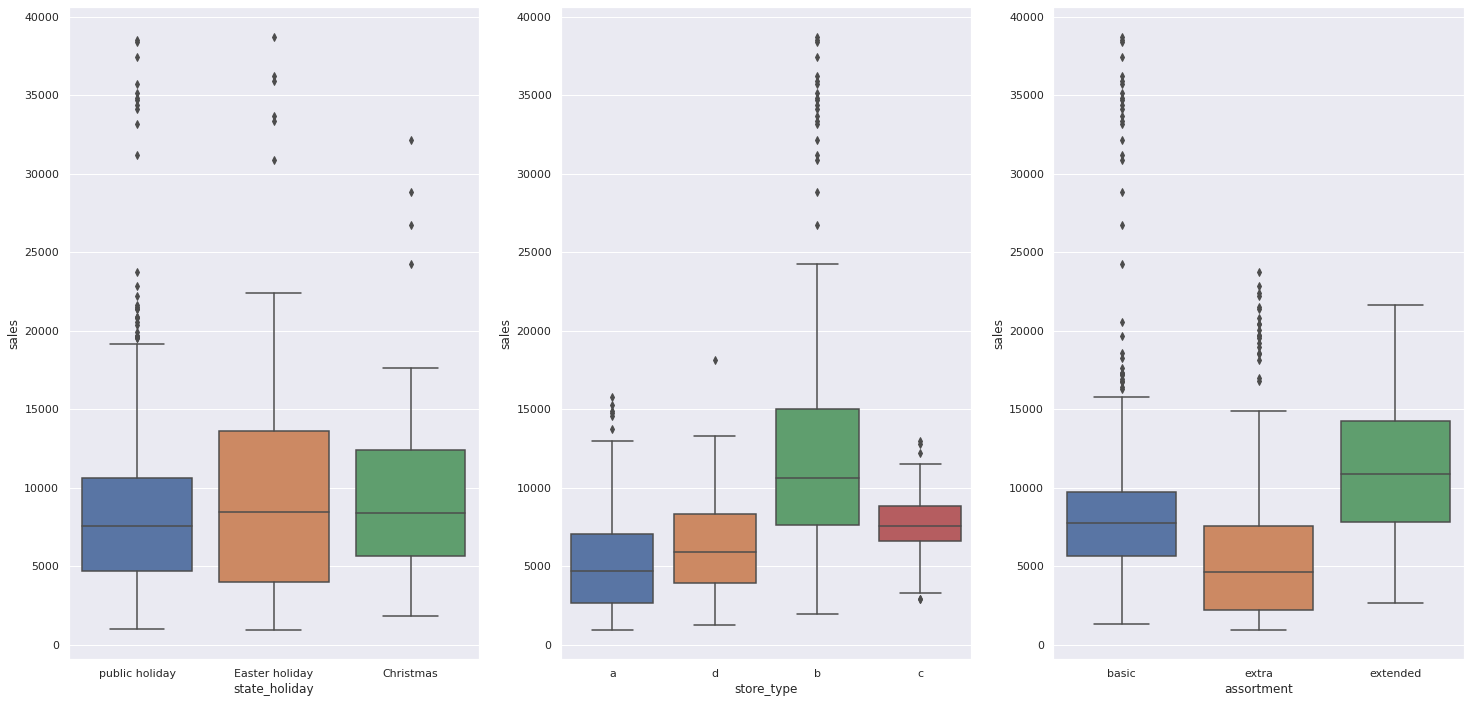

In [20]:
#categorical attributes
aux = df2[(df2['state_holiday'] !='0') & (df2['sales'] > 0)]
   
plt.subplot(1,3,1)
sns.boxplot(x ='state_holiday' , y= 'sales', data = aux);
plt.xticks([0,1,2], ['public holiday','Easter holiday','Christmas']);

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux);

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux);
plt.xticks([0,1,2], ['basic','extra','extended']);

# 4. FEATURE ENGINEERING

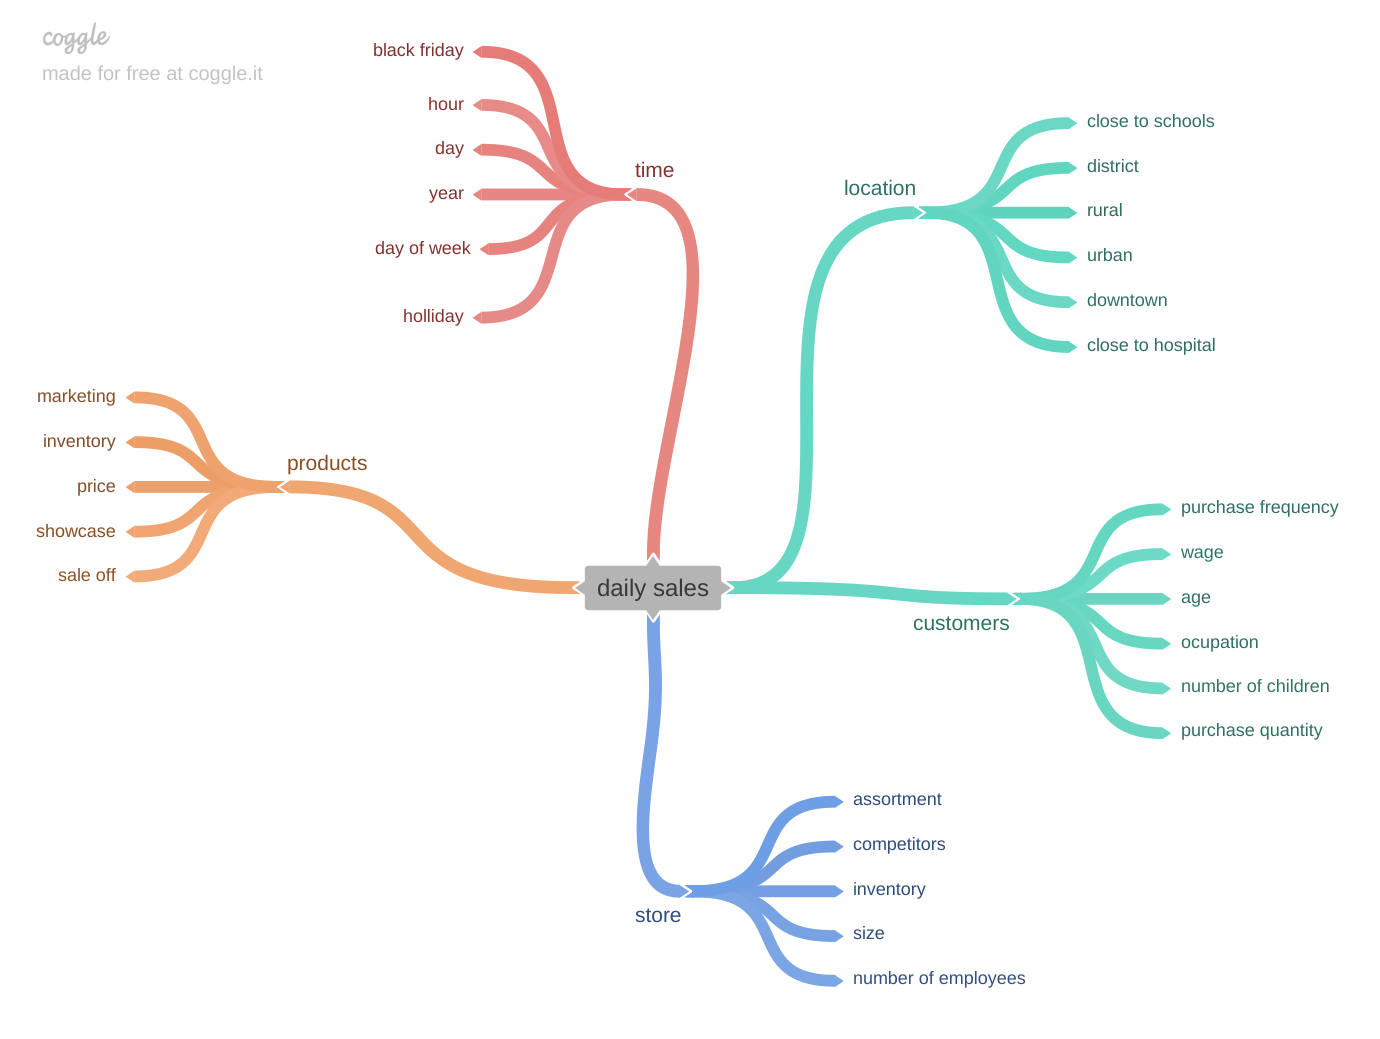

In [11]:
Image('img/mindmap2.png')

In [21]:
df3 = df2.copy()

#year
df3['year'] = df3['date'].dt.year

#month
df3['month'] = df3['date'].dt.month

#day
df3['day'] = df3['date'].dt.day

#week of year
df3['week_of_year'] = df3['date'].dt.isocalendar().week

#year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

#competition since
df3['competition_since'] = df3.apply(lambda x: str(x['competition_open_since_year']) + '-' + str(x['competition_open_since_month']) + '-' + '01', axis=1)
df3['competition_since'] = pd.to_datetime(df3['competition_since'], format = '%Y-%m-%d')
df3['competition_time_days'] = df3.apply(lambda x: x['date'] - x['competition_since'], axis=1)
#transform days into months
df3['competition_time_days'] = df3['competition_time_days'].astype('timedelta64[D]')
df3['competition_time_month'] = df3['competition_time_days']/30
df3['competition_time_month'] = df3['competition_time_month'].astype(int)

#promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df3['promo_time_days'] = df3['date'] - df3['promo_since']
#transform days into weeks
df3['promo_time_days'] = df3['promo_time_days'].astype('timedelta64[D]')
df3['promo_time_weeks'] = df3['promo_time_days']/7
df3['promo_time_weeks'] = df3['promo_time_weeks'].astype(int)

#assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x=='a' else
                                                       'extra' if x=='b' else
                                                        'extended')

#holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else
                                                            'easter_holiday' if x=='b' else
                                                            'christmas' if x=='c' else 
                                                            'regular_day' )


In [27]:
df4 = df3.copy()
#filter lines
df4 = df4.loc[(df4['open'] != 0) & (df4['sales']>0), :] 

#drop auxiliar columns
cols_drop = ['customers', 'open', 'month_map','competition_since','competition_time_days', 'promo_since', 'promo_time_days']
df4 = df4.drop(cols_drop, axis=1)
#customers - will be droped, since we don`t know the number of customers that will be in the stores

# 5. EDA - EXPLORATORY DATA ANALYSIS

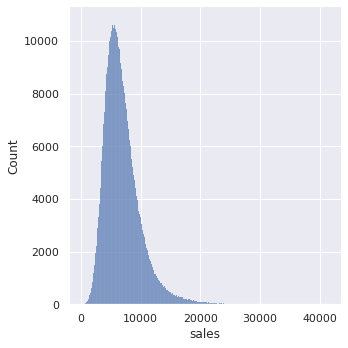

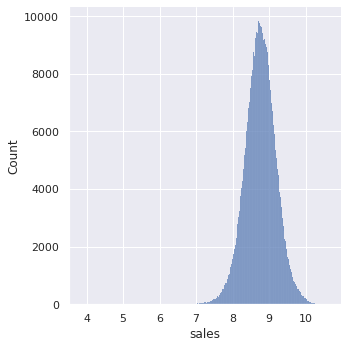

In [29]:
#univariate analysys
df5 = df4.copy()

sns.displot(df5['sales']); 
sns.displot(np.log1p(df5['sales']))

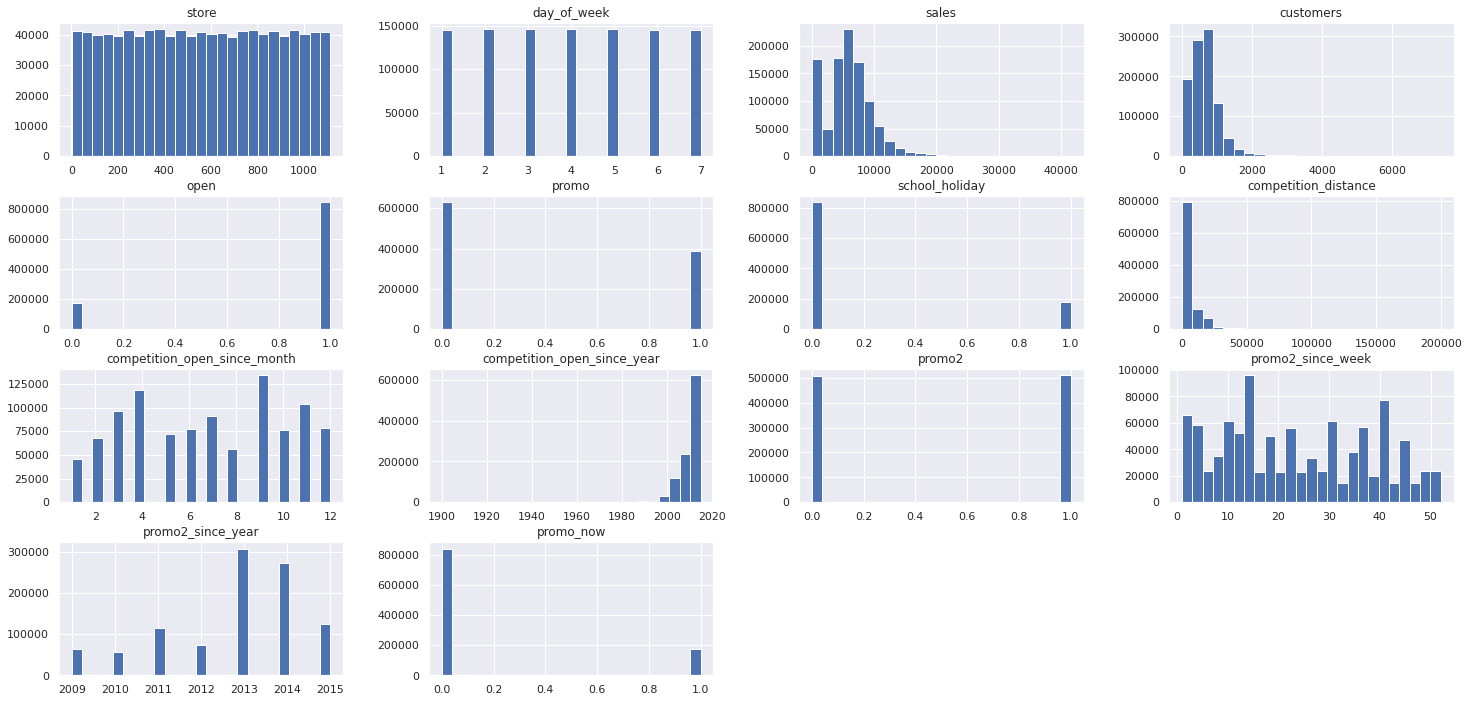

In [30]:
num_attributes.hist(bins=25);

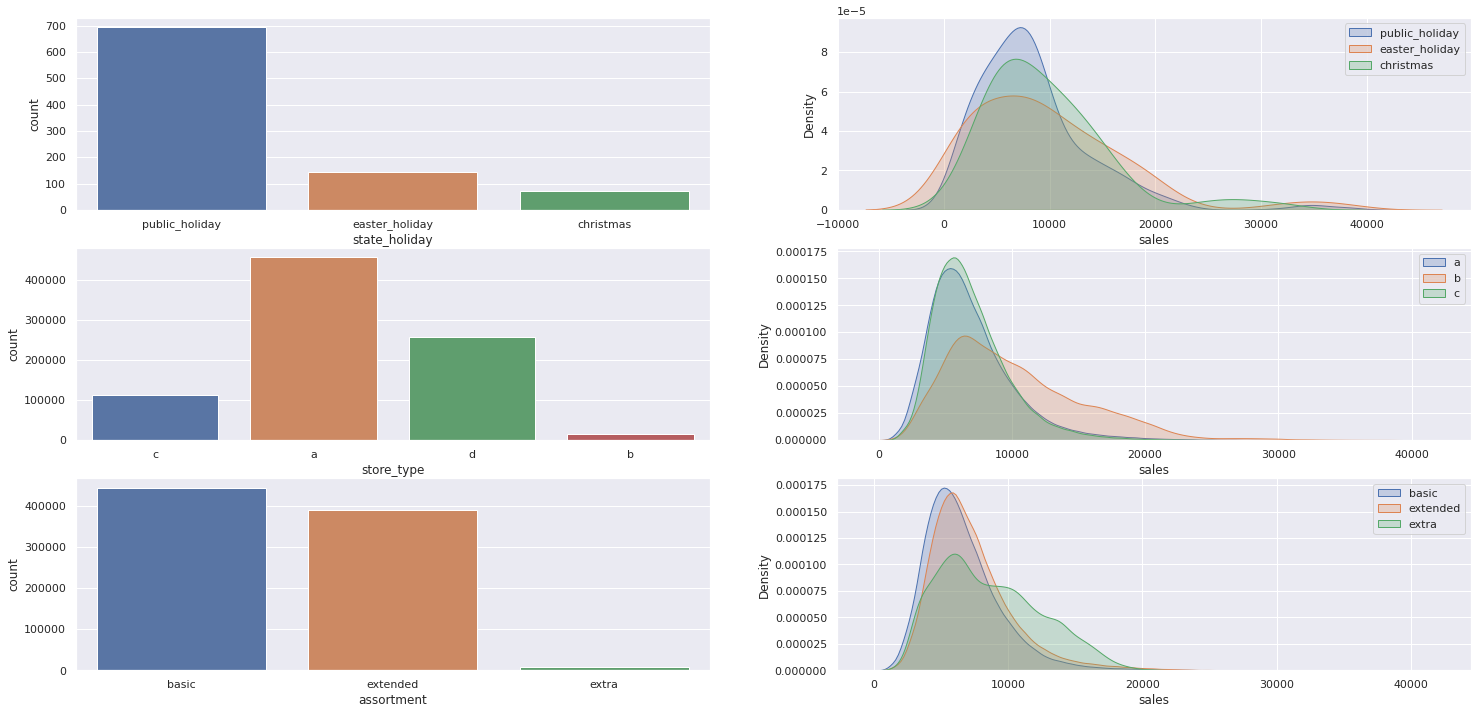

In [75]:
#categorical

#state_holydays
plt.subplot(3,2,1)
a = df5.loc[df5['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label= "public_holiday", shade=True);
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label ='easter_holiday',shade=True);
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label ='christmas', shade=True);
plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot(df5['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label ='a',shade=True);
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label ='b',shade=True);
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label ='c', shade=True);
plt.legend();

#assortment
plt.subplot(3,2,5)
sns.countplot(df5['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], label ='extended',shade=True);
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], label ='extra', shade=True);
plt.legend();

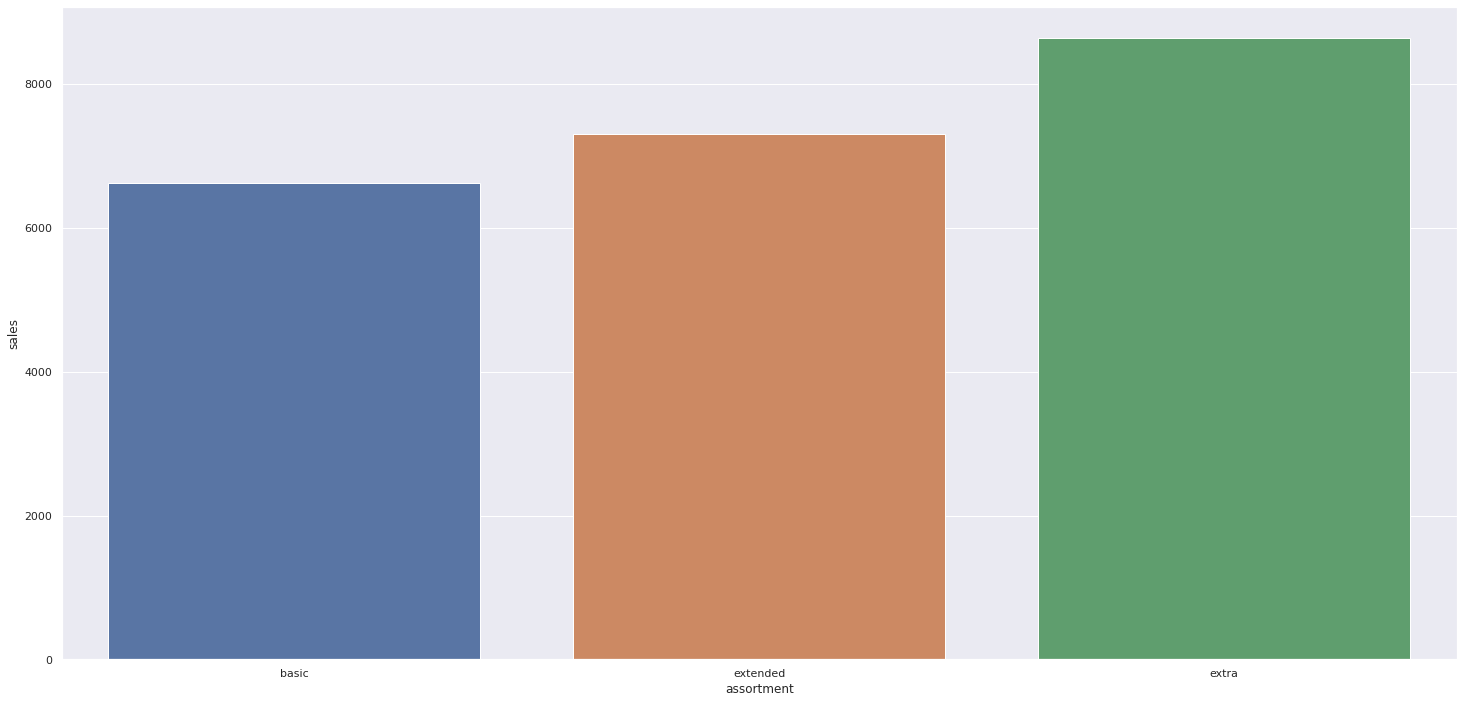

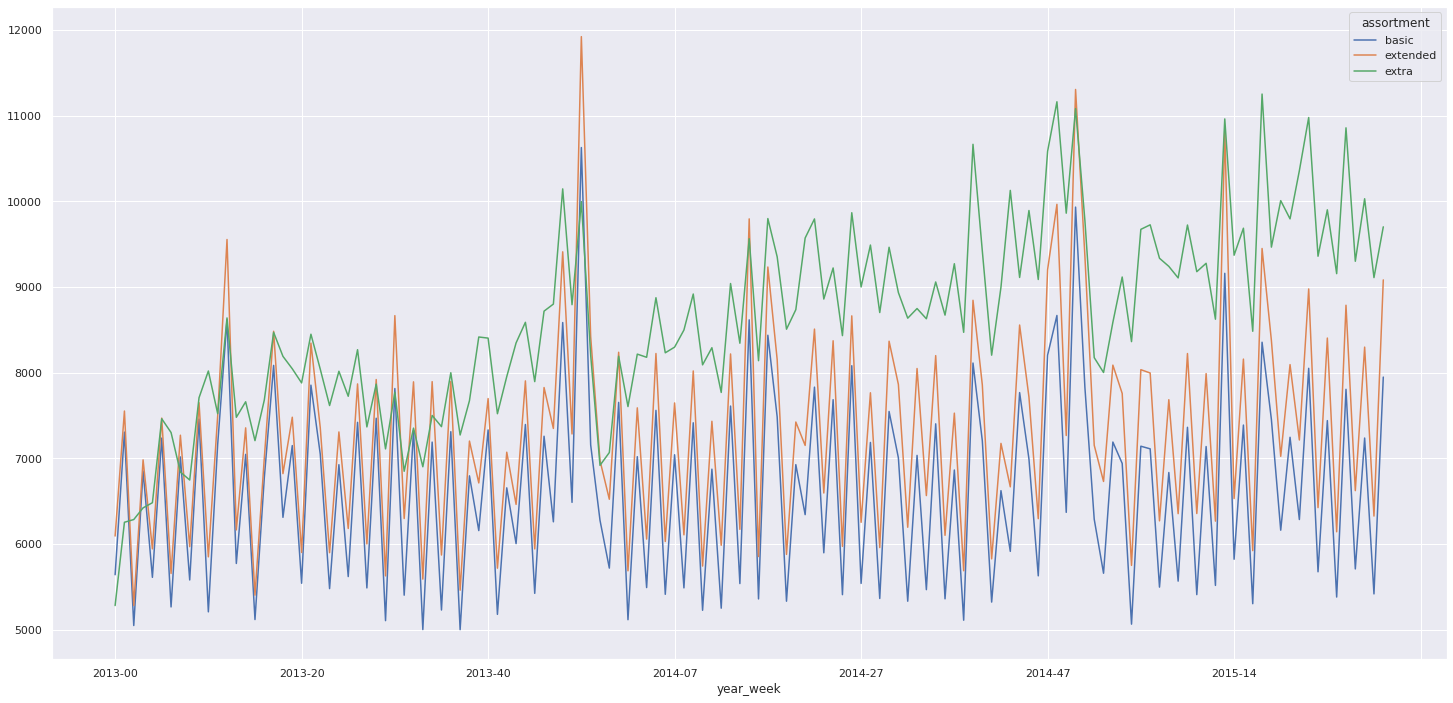

In [76]:
#1)Stores that offer a broad assortment of products sell more  - True

aux1 = df5[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data =aux1 )

assort_sales = df5[['assortment', 'sales','year_week']].groupby(['year_week','assortment']).mean().reset_index()
assort_sales.pivot(index ='year_week', columns = 'assortment', values='sales').plot();

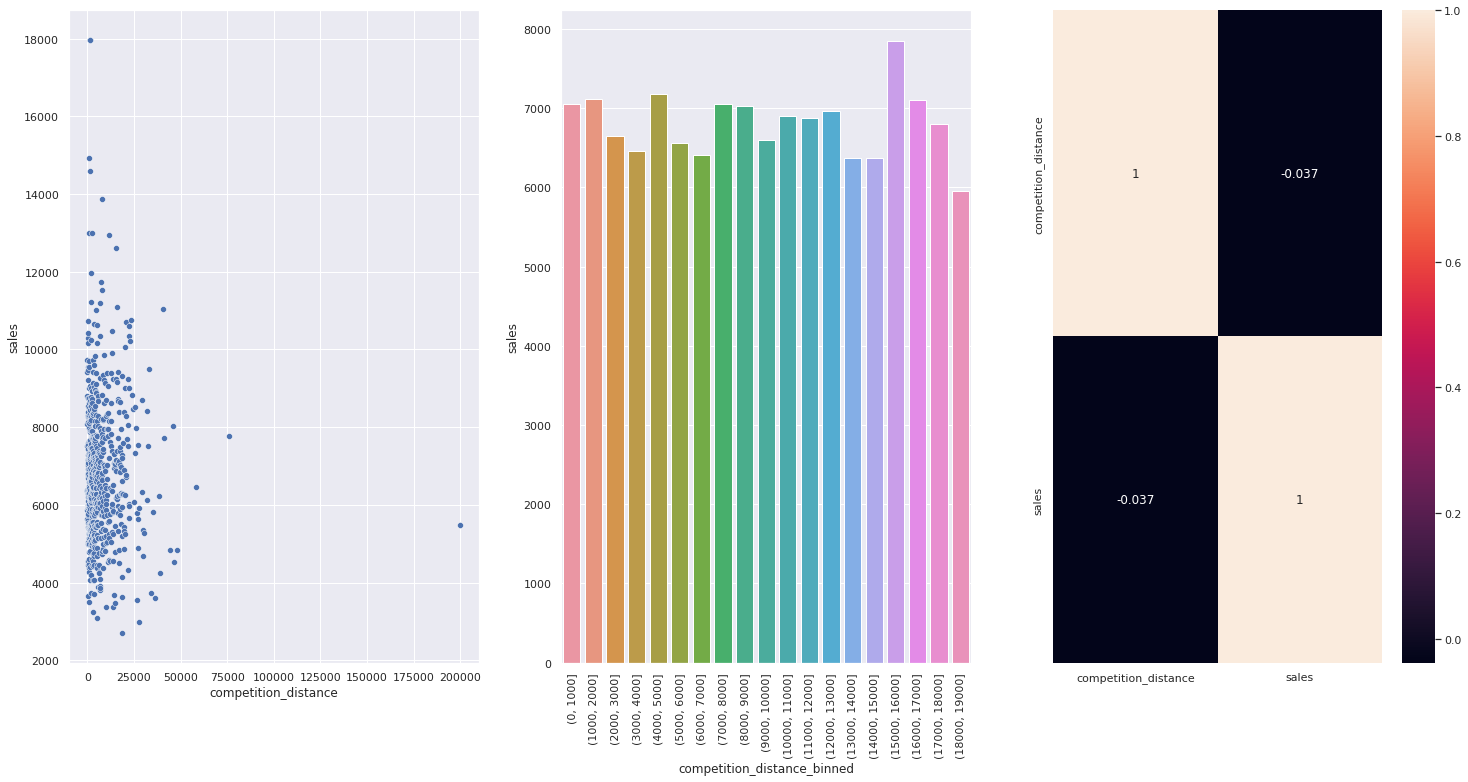

In [38]:
#2)Stores that have competition nearby sell less - False

#dispersion graph
aux1 = df5[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1)

#histogram
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['sales','competition_distance_binned']].groupby('competition_distance_binned').mean().reset_index()
plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y ='sales', data = aux2);
plt.xticks(rotation=90);

#correlation
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

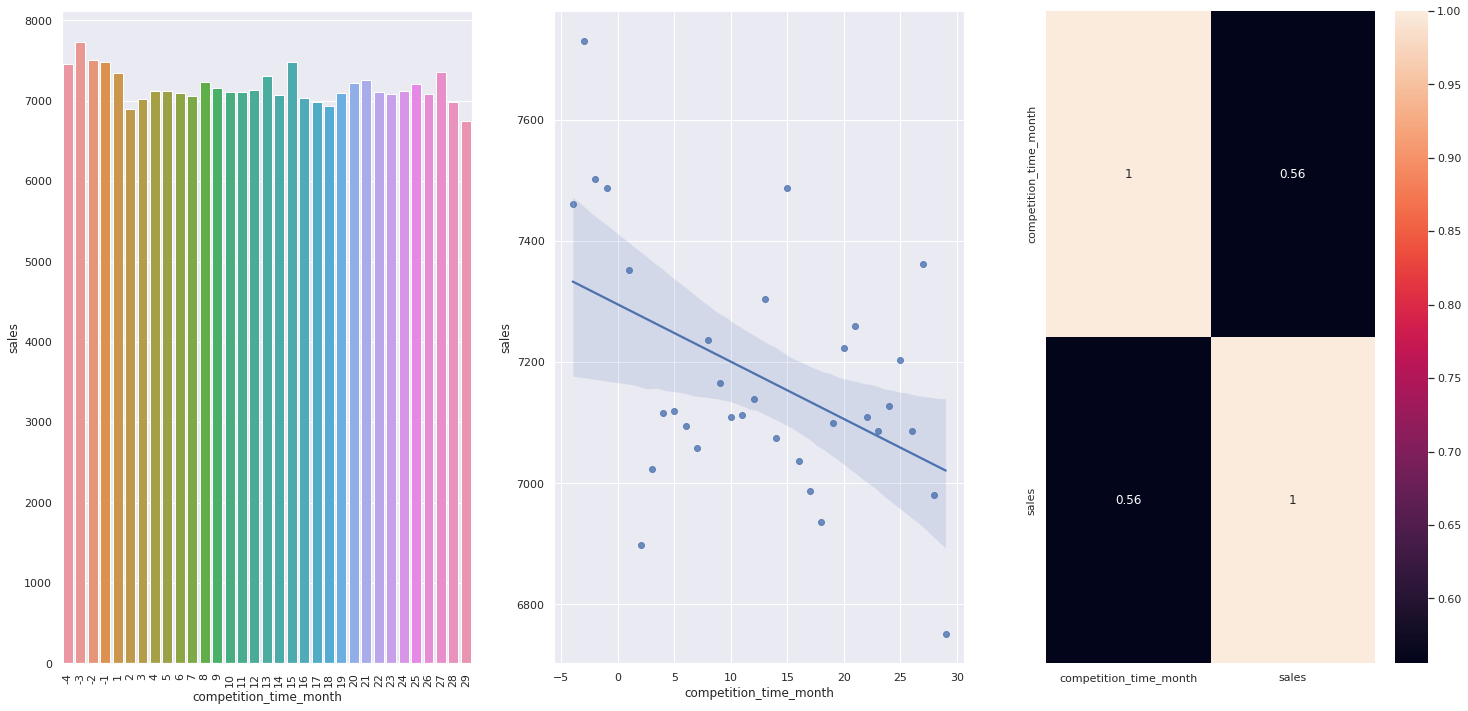

In [35]:
#3) stores that have competition for a longer period of time, sell more - True

#lojas com competidores a mais tempo vendem mais
aux1 = df5[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1.loc[(aux1['competition_time_month'] <30) &(aux1['competition_time_month'] >-5) & (aux1['competition_time_month'] != 0 )]

plt.subplot(1,3,1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month', y='sales' , data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


<AxesSubplot:xlabel='year', ylabel='sales'>

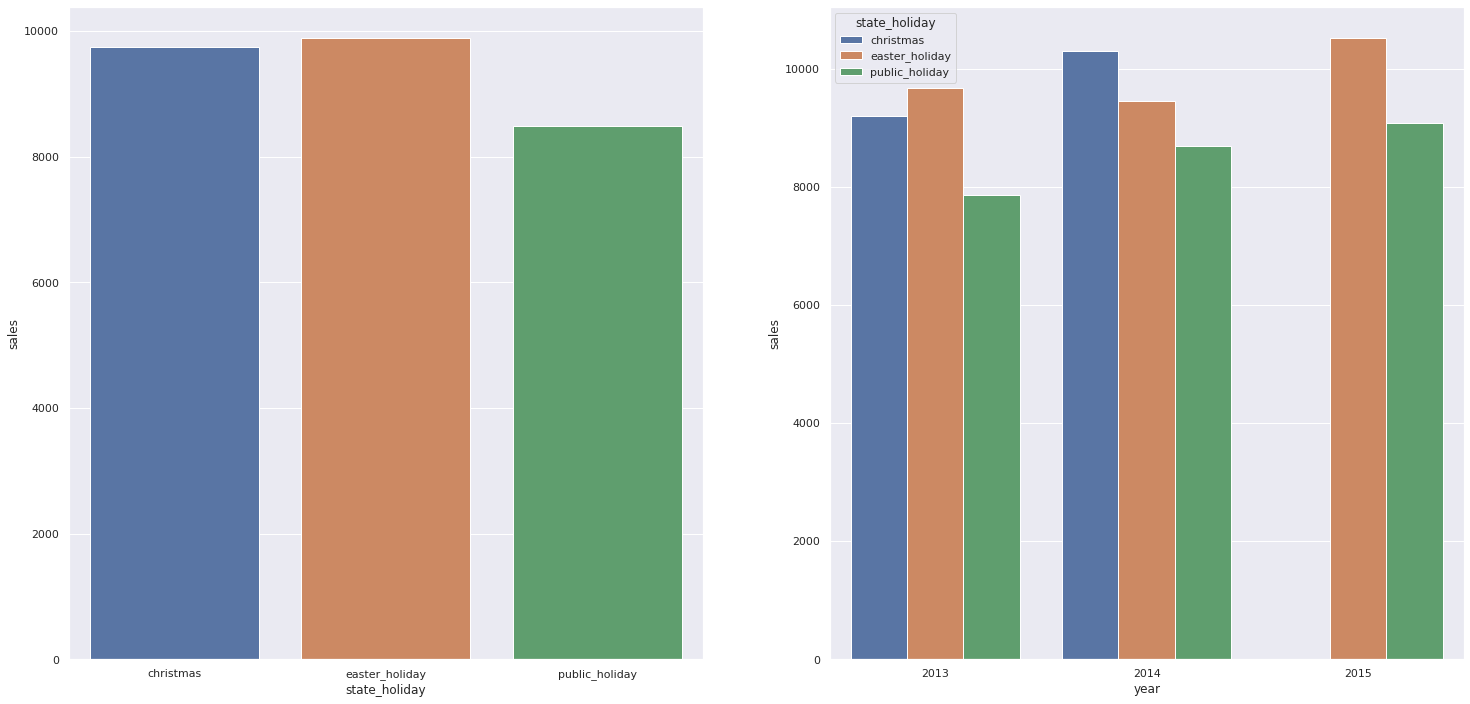

In [41]:
#4)There are more sales on Christmas than on the other holidays - False

aux1 = df5.loc[df5['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x ='state_holiday',y ='sales',data = aux2);

aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).mean().reset_index();

plt.subplot(1,2,2)
sns.barplot(x ='year',y ='sales', hue = 'state_holiday',  data = aux3)

##### 

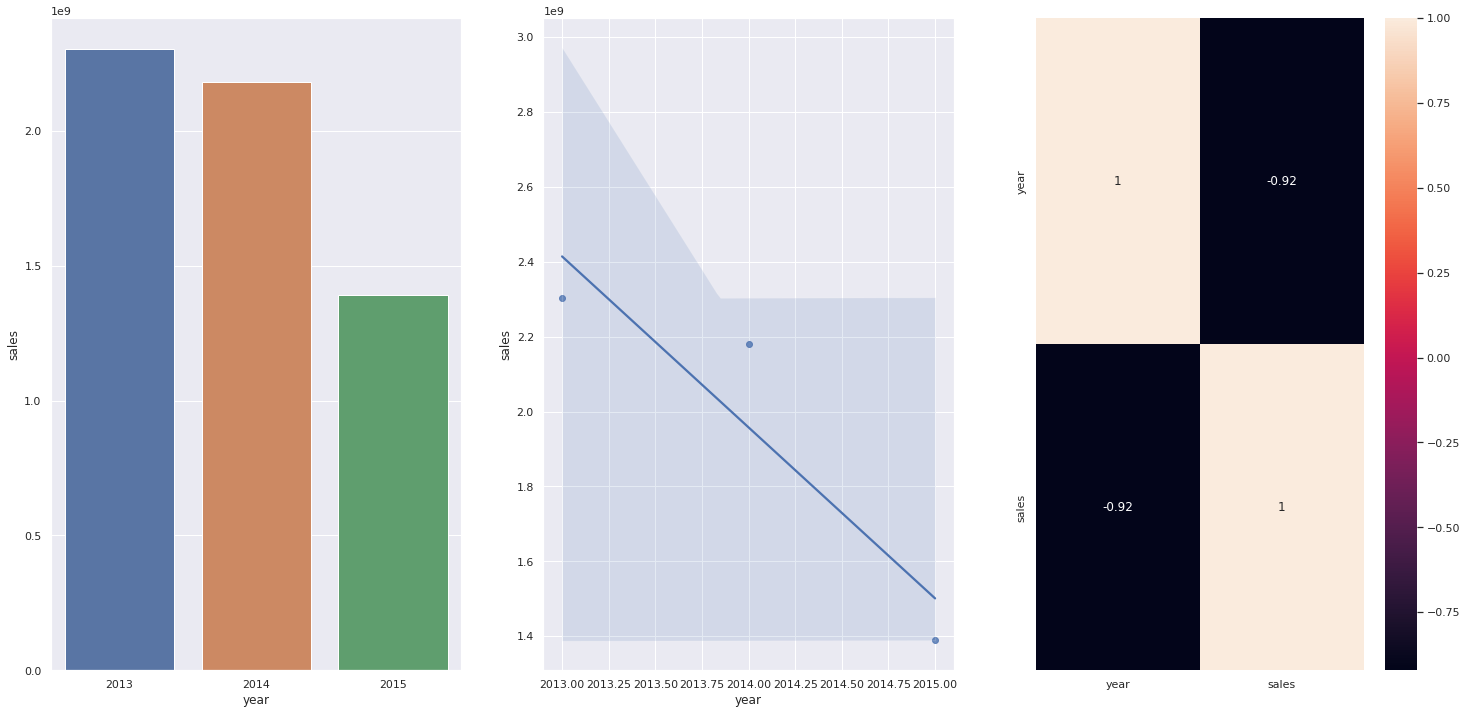

In [49]:
#5)stores sell more over the years - False

aux1 = df5[['sales', 'year']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year' , y='sales' , data =aux1 );

plt.subplot(1,3,2)
sns.regplot(x='year' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);


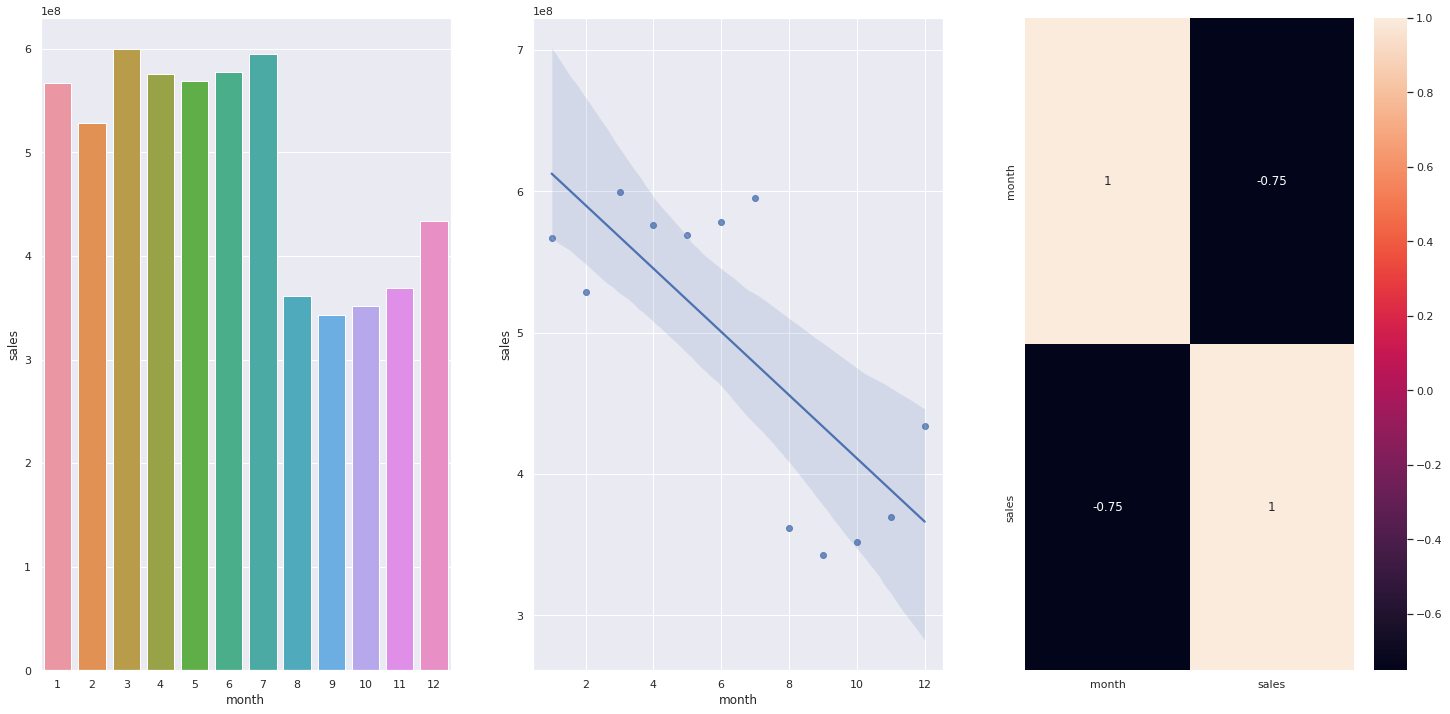

In [50]:
#6)Stores sell more in the second semester of the year - False

aux1 = df5[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month' ,y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x='month' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

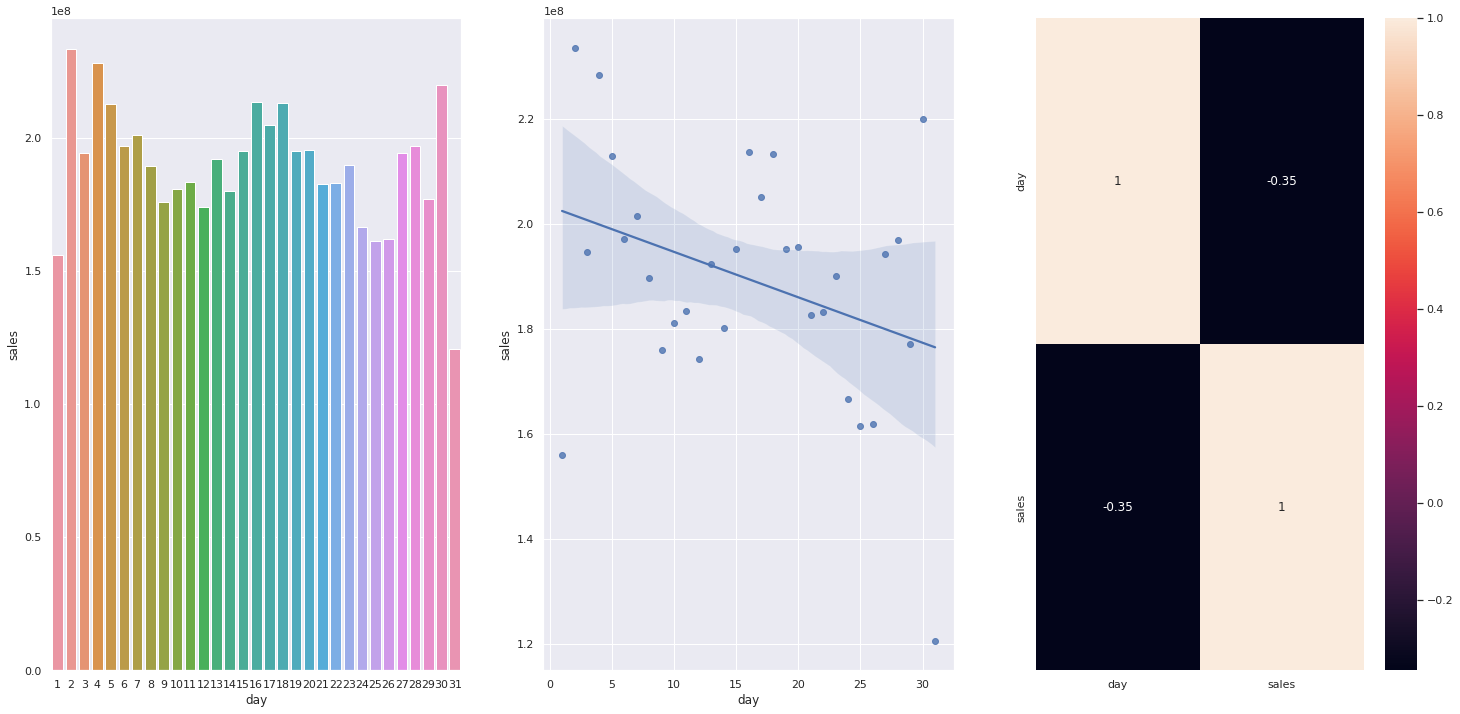

In [51]:
#7)Stores sell more in the last days of the month  - False
aux1 = df5[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day' ,y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x='day' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

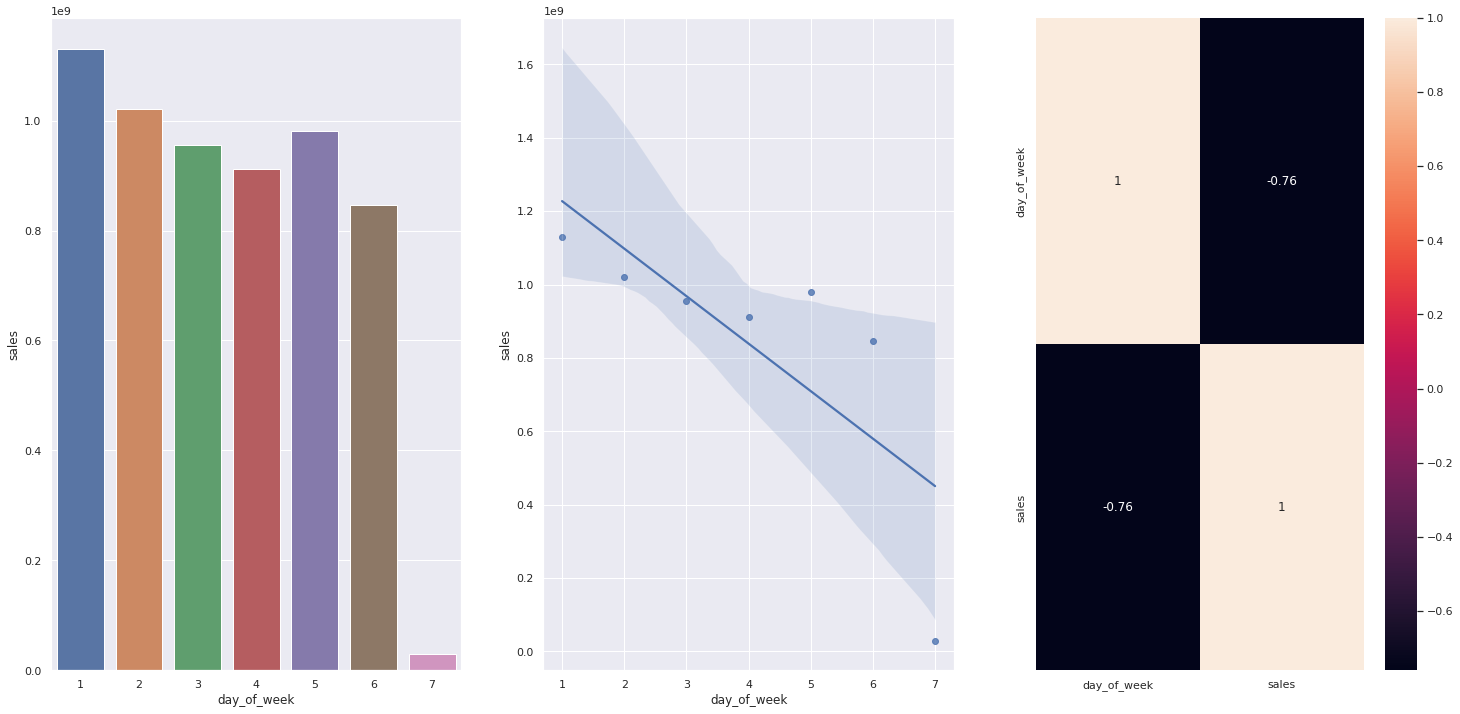

In [52]:
#8)Stores sell less on the weekends** - True

aux1 = df5[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week' ,y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

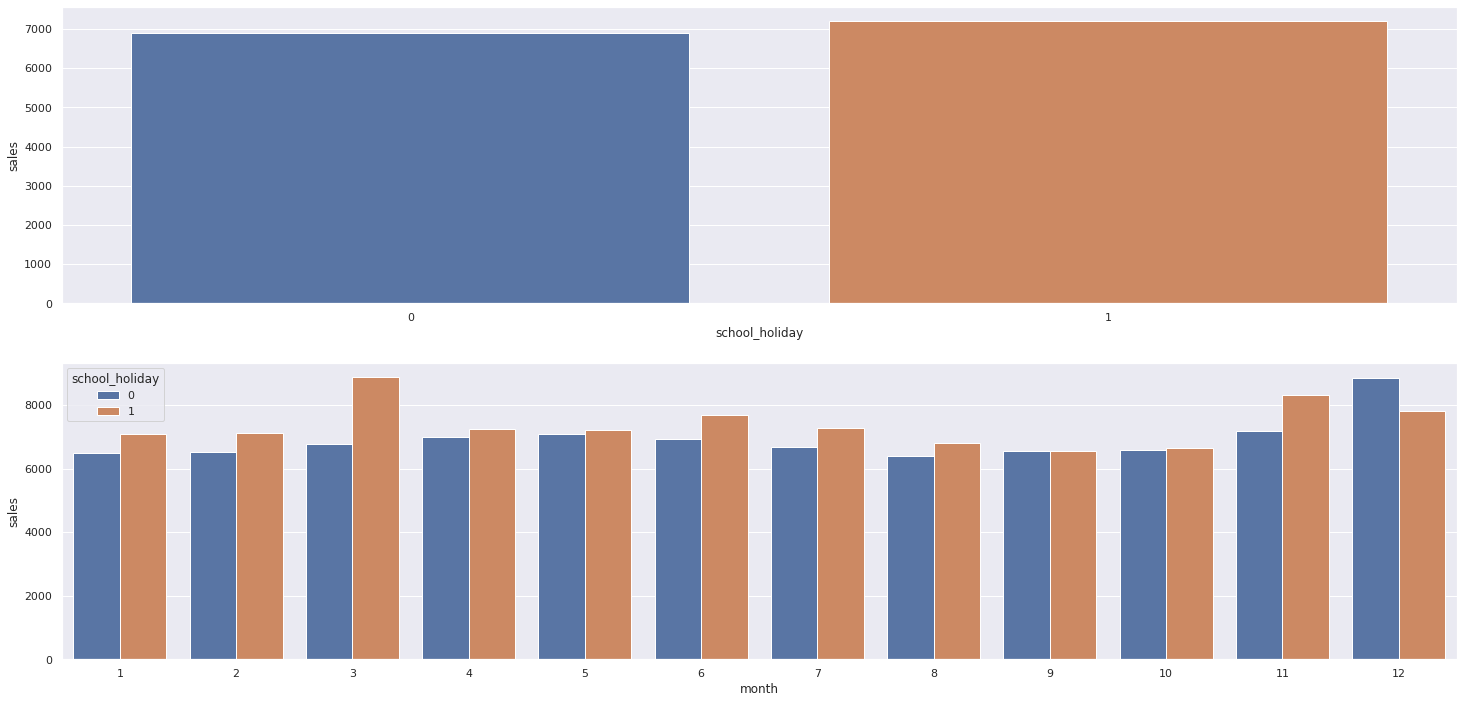

In [55]:
#Stores sell less in the school holidays - False 

plt.subplot(2,1,1)
aux1 = df5[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df5[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

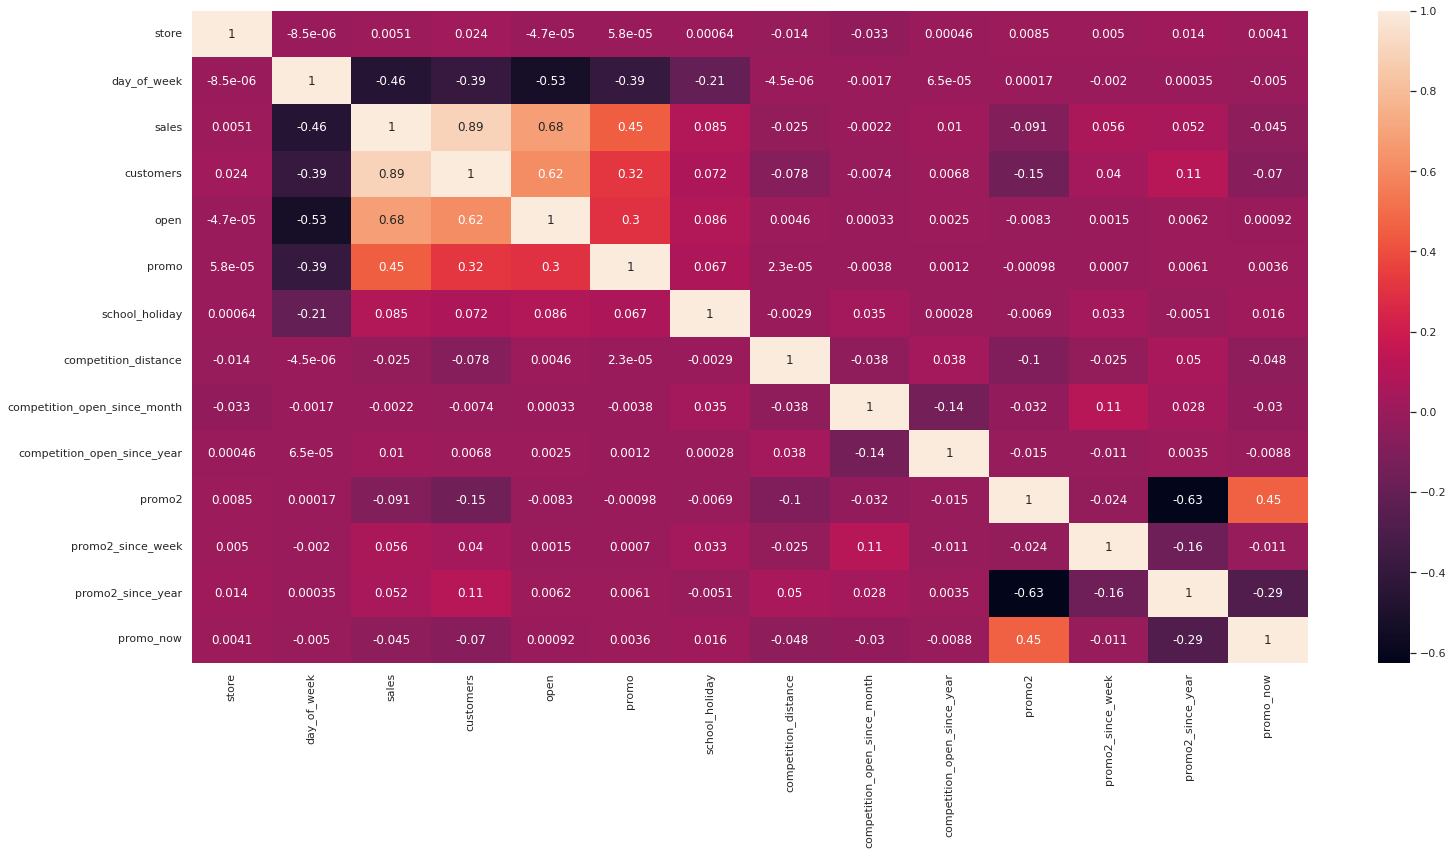

In [56]:
#multivariate analysis
#numerical attributes
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

<AxesSubplot:>

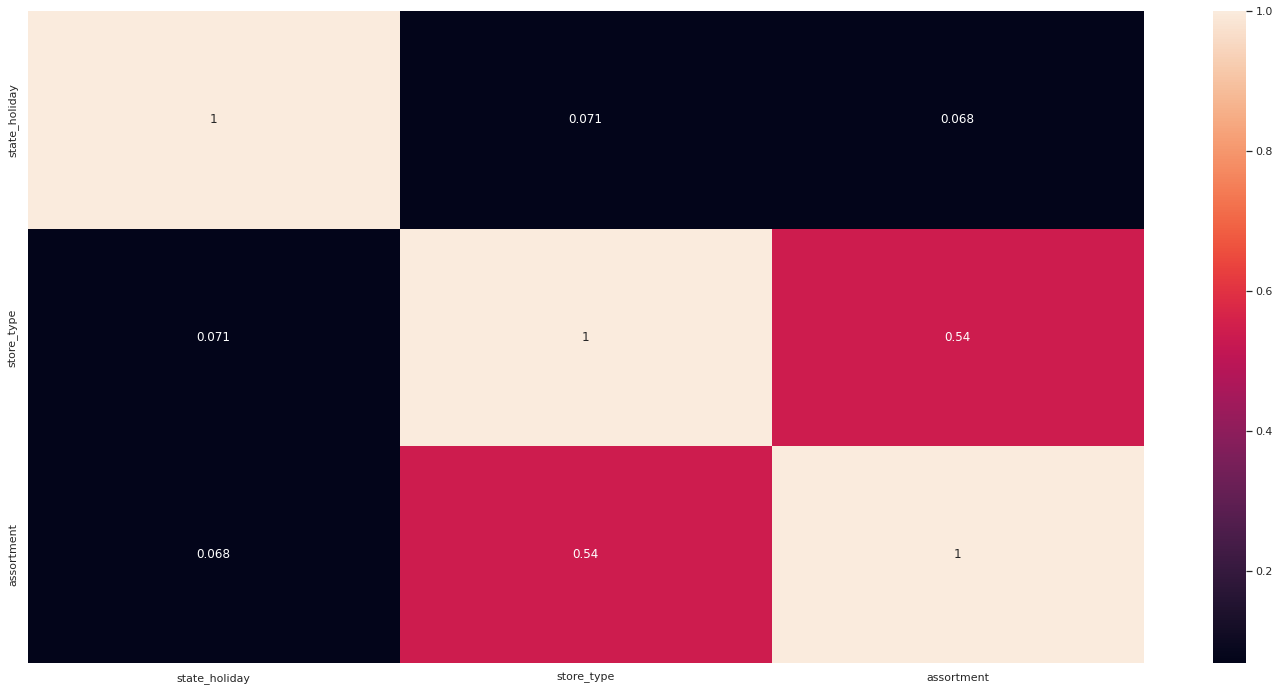

In [57]:
#filter categorical data
b = df5.select_dtypes(include = 'object')

#calculate cramer v
a1 = cramer_v(b['state_holiday'], b['state_holiday'])
a2 = cramer_v(b['state_holiday'], b['store_type'])
a3 = cramer_v(b['state_holiday'], b['assortment'])

a4 = cramer_v(b['store_type'], b['state_holiday'])
a5 = cramer_v(b['store_type'], b['store_type'])
a6 = cramer_v(b['store_type'], b['assortment'])

a7 = cramer_v(b['assortment'], b['state_holiday'])
a8 = cramer_v(b['assortment'], b['store_type'])
a9 = cramer_v(b['assortment'], b['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3], 
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9] })

#final dataset
d = d.set_index(d.columns)
sns.heatmap(d, annot = True)

# 6. DATA PREPARING

In [59]:
#rescaling
df6  = df5.copy()
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)
pickle.dump(rs, open ('parameter/competition_distance_scaler.pkl', 'wb'))

#competition_time_month
df6['competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values)
pickle.dump(rs, open ('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo_time_weeks
df6['promo_time_weeks'] = mms.fit_transform(df6[['promo_time_weeks']].values)
pickle.dump(mms, open ('parameter/promo_time_weeks_scaler.pkl', 'wb'))

#year
df6['year'] = mms.fit_transform(df6[['year']].values)
pickle.dump(mms, open ('parameter/year_scaler.pkl', 'wb'))

In [60]:
#encoding
#state_holiday
#one hot encoding
df6 = pd.get_dummies(df6, prefix=['state_holiday'], columns = ['state_holiday'])

#store_type
#label encoding
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment
#ordinal encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df6['assortment'] = df6['assortment'].map(assortment_dict)

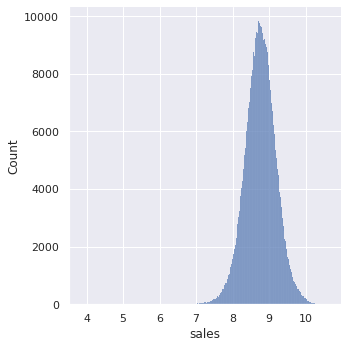

In [61]:
#normalize response variable
#response variable transformation
df6['sales'] = np.log1p(df6['sales'])
sns.displot(df6['sales']);

In [62]:
#ciclical features

#day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

#month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

#day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

#week of year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 7. FEATURE SELECTION

In [63]:
df7 = df6.copy()

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week','promo_interval', 'year_week']
df7 = df7.drop(cols_drop, axis=1)

#split dataframe into training and test dataset
#df7[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

#training dataset
X_train = df7[df7['date']<'2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']

In [41]:
#training and test dataset for Boruta
#x_train_n = x_train.drop(['date','sales'], axis = 1).values 
#y_train_n = y_train.values.ravel() 

#define RandomForestRegressor
#rf = RandomForestRegressor (n_jobs = -1) 

#define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n) 


In [42]:
#cols_selected = boruta.support_.tolist

#best features
#x_train_fs = x_train.drop(['date', 'sales'],axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta))

In [64]:
#columns_selected_boruta
cols_selected_boruta = ['store',
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_weeks',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']
#columns to add
feat_to_add = ['date','sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 8. MACHINE LEARNING MODELING

In [65]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

In [77]:
#average model
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error ('Average Model', np.expm1(y_test), np.expm1 (yhat_baseline))

In [78]:
#linear regression
lr = LinearRegression().fit(x_train, y_train)

#prediction 
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))

#linear regression - cross validation
model = LinearRegression()
lr_result_cv = cross_validation (x_training, 5, 'Linear Regression', lr)

In [79]:
#linear regression regularized - lasso
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction 
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))

#linear regression regularized - cross validation
lrr = Lasso(alpha=0.01).fit(x_train, y_train)
lrr_result_cv = cross_validation (x_training, 5, 'Lasso', lrr)

In [80]:
#XGBoost regression
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9).fit(x_train, y_train)
                           
#prediction 
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

#XGBoost - cross validation
xgb_result_cv = cross_validation (x_training, 5, 'XGBoost', model_xgb)

In [81]:
#single performance
models_results = pd.concat([baseline_result,lr_result, lrr_result, xgb_result])
models_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,871.700239,0.126330,1280.431050
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.836981,0.292891,2672.358516
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


In [82]:
#real performance - cross validartion
models_results_cv = pd.concat([lr_result_cv, lrr_result_cv, xgb_result_cv])
models_results_cv.sort_values('RMSE CV')


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1044.24 +/- 167.49,0.14 +/- 0.02,1504.4 +/- 229.6
0,Linear Regression,2082.37 +/- 295.54,0.3 +/- 0.02,2953.01 +/- 467.76
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 9. HYPERPARAMETER FINE TUNING

In [53]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight':[3, 8, 15] }
MAX_EVAL = 5

In [57]:
# final_result = pd.DataFrame()
# for i in range (MAX_EVAL):
#     #choose values randomly   
#     hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#     print(hp)
#     #XGBoost regression
#     model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#                                
#
#     #performance
#     result = cross_validation (x_training, 2, 'XGBoost Regressor', model_xgb)
#     final_result = pd.concat([final_result,result ])

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}


In [60]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,986.69 +/- 78.03,0.14 +/- 0.01,1406.78 +/- 128.57
0,XGBoost Regressor,1017.92 +/- 76.76,0.14 +/- 0.01,1452.32 +/- 128.55
0,XGBoost Regressor,948.34 +/- 86.37,0.13 +/- 0.01,1336.72 +/- 158.64
0,XGBoost Regressor,909.65 +/- 113.66,0.12 +/- 0.01,1292.08 +/- 193.55
0,XGBoost Regressor,903.49 +/- 100.38,0.12 +/- 0.01,1306.01 +/- 173.07


In [54]:
#final model with parameters tuned
param_tuned = {'n_estimators':3000 ,
        'eta': 0.03,
        'max_depth':5 ,
        'subsample':0.1 ,
        'colsample_bytree':0.9 ,
        'min_child_weight':3 }

In [65]:
#XGBoost regression
model_xgb_tuned = xgb.XGBRegressor(objective ='reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
                                   

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)




#performance
xgb_result_error = ml_error ('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_error

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,699.57267,0.102399,1009.073629


# 10. INTERPRETING THE ERROR

In [102]:
#business performance
df8 = X_test[cols_selected_boruta_full]

#reescale
df8['sales'] = np.expm1(df8['sales'])
df8['predictions'] = np.expm1(yhat_xgb_tuned)

#sum of predictions
df81 = df8[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df8_aux_1 = df8[['store','sales','predictions']].groupby('store')
df8_aux_1 = df8_aux_1.apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index()

df8_aux_2 = df8[['store','sales','predictions']].groupby('store')
df8_aux_2 = df8_aux_2.apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index()

df8_aux_3 = pd.merge (df8_aux_1, df8_aux_2, how = 'inner', on='store')
df9 = pd.merge (df81, df8_aux_3, how = 'inner', on='store')

df9 = df9.rename(columns ={'store': 'store', 'predictions': 'predictions', '0_x': 'MAE', '0_y': 'MAPE'})

#Scenarios
#worst scenario
df9['worst_scenario'] = df9['predictions'] - df9['MAE']

#best scenario
df9['best_scenario'] = df9['predictions'] + df9['MAE']

df9 = df9[['store', 'predictions', 'best_scenario', 'worst_scenario','MAE', 'MAPE']]


In [103]:
df9.head(20)
df9.sort_values('MAPE', ascending = False).head(20)

,store,predictions,best_scenario,worst_scenario,MAE,MAPE
291,292,103509.578125,106806.039217,100213.117033,3296.461092,0.539909
908,909,241141.578125,248520.668181,233762.488069,7379.090056,0.503596
875,876,202002.296875,205950.086521,198054.507229,3947.789646,0.312363
721,722,352810.000000,354796.865089,350823.134911,1986.865089,0.267348
273,274,197443.562500,198782.167151,196104.957849,1338.604651,0.234801
333,334,227514.703125,228663.345334,226366.060916,1148.642209,0.226468
656,657,234500.734375,235565.616884,233435.851866,1064.882509,0.223573
577,578,341358.968750,343721.455805,338996.481695,2362.487055,0.217949
594,595,413537.625000,416663.986170,410411.263830,3126.361170,0.212382
1072,1073,283675.062500,285643.469120,281706.655880,1968.406620,0.211750


<AxesSubplot:xlabel='store', ylabel='MAPE'>

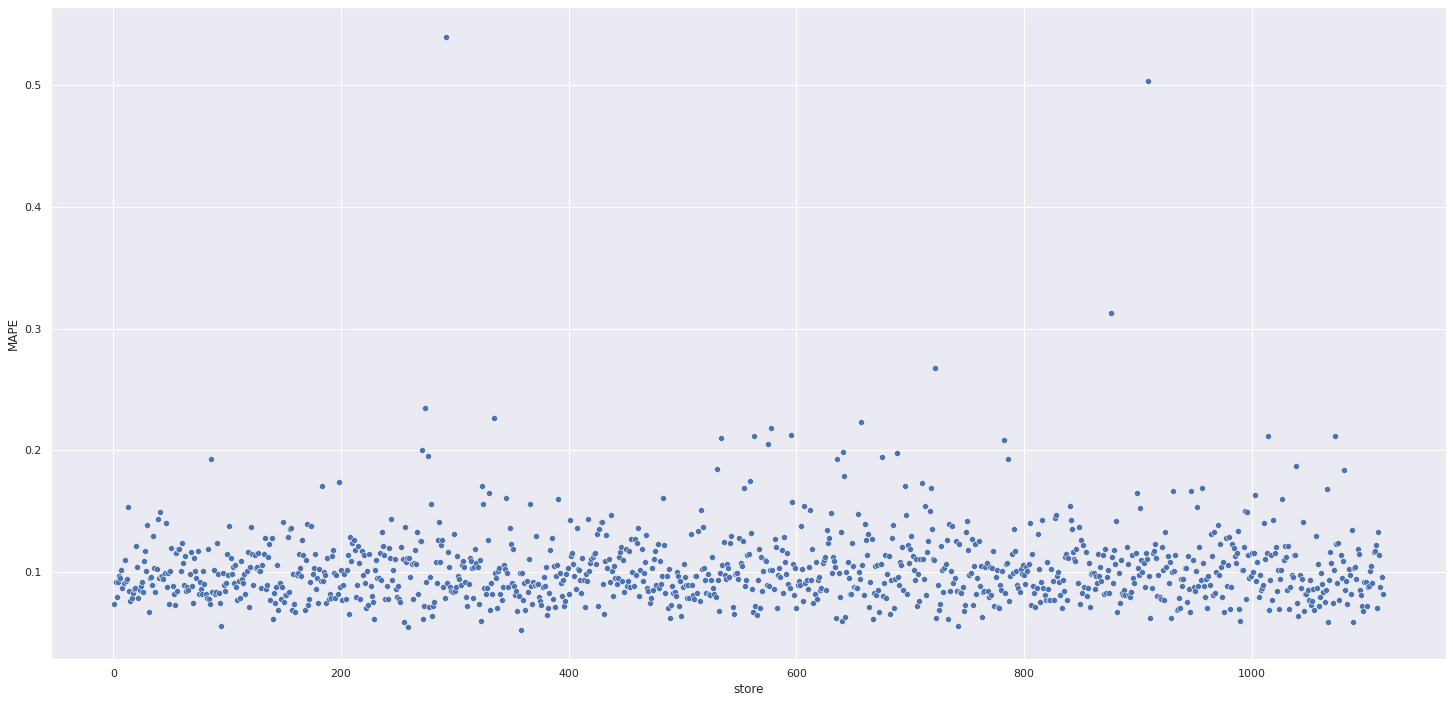

In [104]:
sns.scatterplot(x='store', y='MAPE', data =df9)

# 11. TOTAL PERFORMANCE

In [111]:
df10 = df9[['predictions', 'best_scenario', 'worst_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index()
df10 = df10.rename(columns = {'index':'scenario',  0:'total sales' })
df10['total sales'] = df10['total sales'].map('R${:,.2f}'.format)

In [112]:
df10

,scenario,total sales
0,predictions,"R$284,191,744.00"
1,best_scenario,"R$284,975,306.72"
2,worst_scenario,"R$283,408,168.78"


In [117]:
df8['error'] = df8['sales'] - df8['predictions']
df8['error_rate'] = df8['predictions'] / df8['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

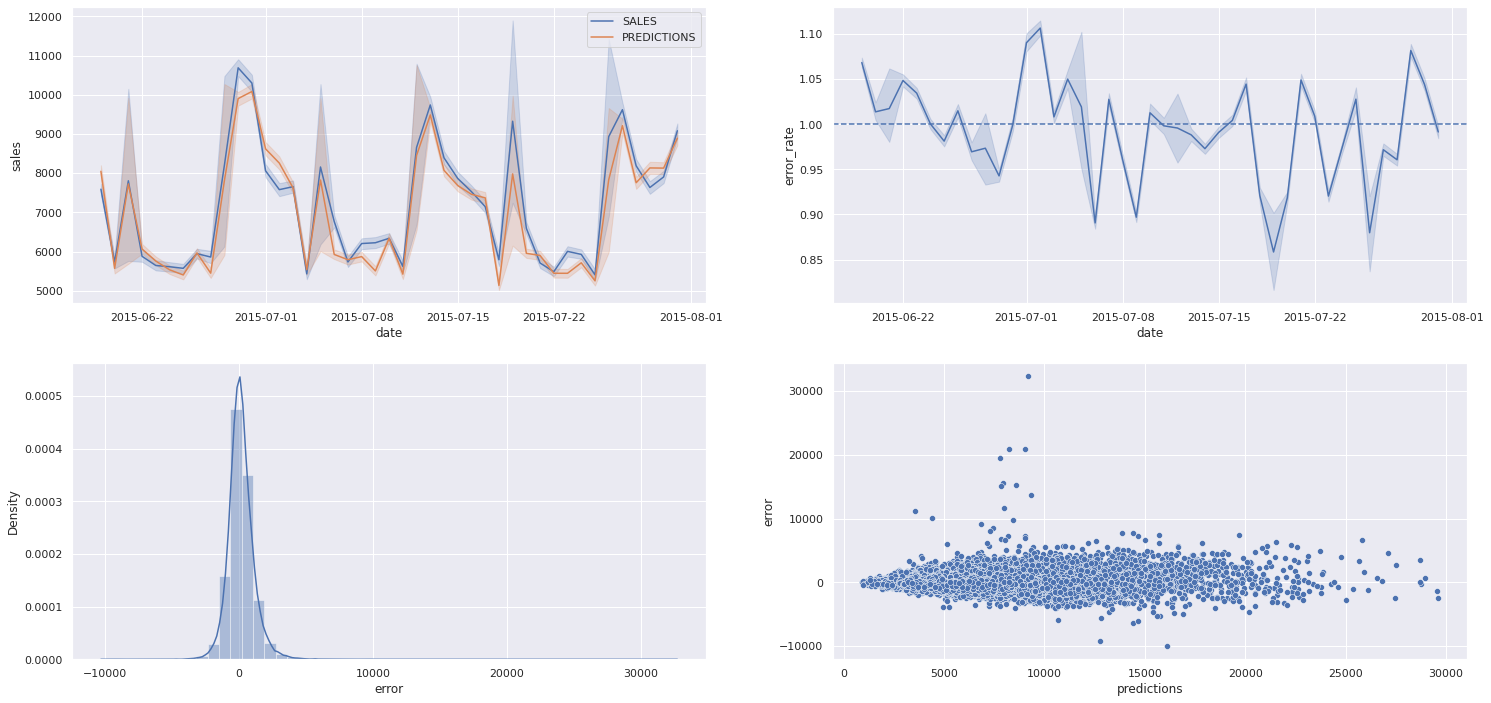

In [127]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data = df8, label='SALES');
sns.lineplot(x='date', y='predictions', data = df8, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y='error_rate', data=df8);
plt.axhline(1, linestyle= '--');

plt.subplot(2,2,3)
sns.distplot(df8['error']);

plt.subplot(2,2,4)
sns.scatterplot(df8['predictions'], df8['error']);


In [ ]:
#save trained model
pickle.dump(model_xgb_tuned, open('model_rossman.pkl', 'wb'))